# Chapter 9: Hypothesis testing

In [1]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, ttest_ind
import pingouin as pg
import matplotlib

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['PhysActive', 'BMI', 'BPSysAve']).query('Age > 17 and BPSysAve > 0')

rng = np.random.default_rng(123456)


## Table 9.1

In [2]:
sampSize = 250
NHANES_sample = NHANES_adult.dropna(subset=['BPSysAve']).sample(sampSize, random_state=rng)
healthGen_recoder = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Vgood': 4, 'Excellent': 5}

sampleSummary = NHANES_sample.groupby('PhysActive')['BPSysAve'].describe()[['count', 'mean', 'std']]

print(sampleSummary)

sampleSummaryDiff = sampleSummary.diff().loc['Yes',:]

s1, s2 = sampleSummary['std'].values
n1, n2 = sampleSummary['count'].values

welch_df = (s1/n1 + s2/n2)**2 / ((s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1))



            count        mean        std
PhysActive                              
No          124.0  122.290323  22.539495
Yes         126.0  118.285714  15.404341


## Figure 9.1

Text(0, 0.5, 'Average systolic blood pressure')

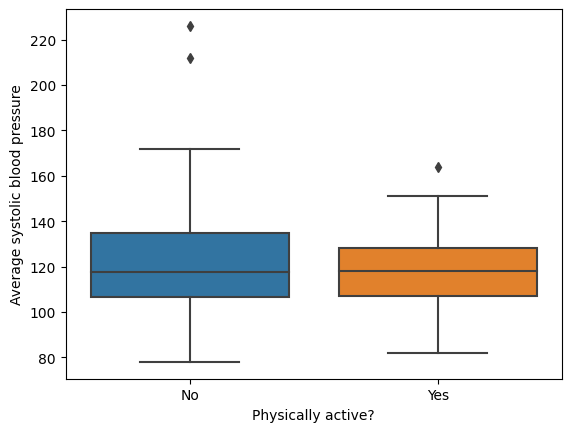

In [3]:
sns.boxplot(data=NHANES_sample, x='PhysActive', y='BPSysAve')
plt.xlabel('Physically active?')
plt.ylabel('Average systolic blood pressure')



## Figure 9.2

Text(0, 0.5, 'density')

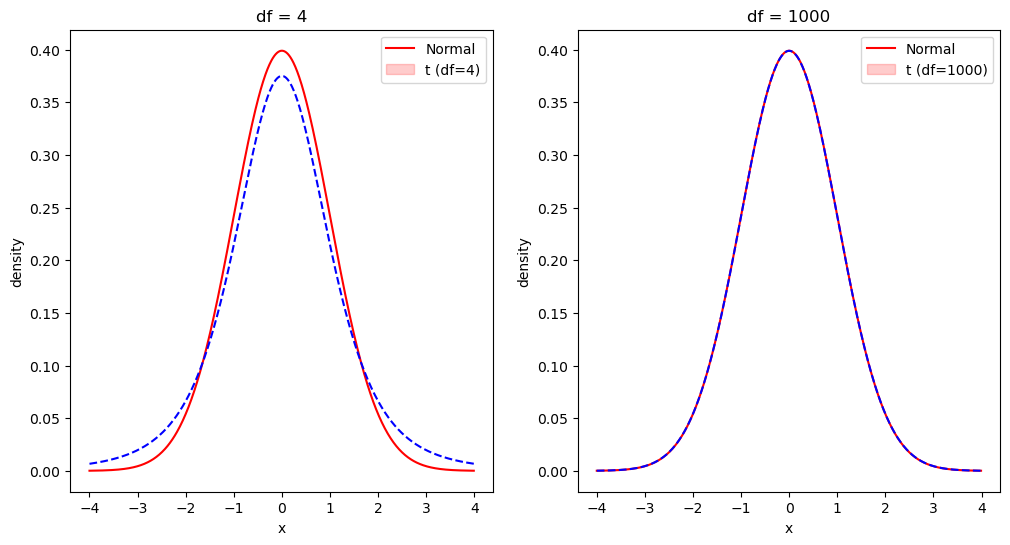

In [4]:
distDfNormal = pd.DataFrame({'x': np.arange(-4, 4, .01)})
distDfNormal['dnorm'] = norm.pdf(distDfNormal.x)
distDfNormal['dt4'] = t.pdf(distDfNormal.x, 4)
distDfNormal['dt1000'] = t.pdf(distDfNormal.x, 1000)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.lineplot(data=distDfNormal, x='x',  y='dnorm', ax=ax[0], color='red')
sns.lineplot(data=distDfNormal, x='x',  y='dt4', ax=ax[0], color='blue', linestyle='dashed')
ax[0].legend(['Normal', 't (df=4)'])
ax[0].set_title('df = 4')
ax[0].set_ylabel('density')

sns.lineplot(data=distDfNormal, x='x',  y='dnorm', ax=ax[1], color='red')
sns.lineplot(data=distDfNormal, x='x',  y='dt1000', ax=ax[1], color='blue', linestyle='dashed')
ax[1].legend(['Normal', 't (df=1000)'])
ax[1].set_title('df = 1000')
ax[1].set_ylabel('density')


## Figure 9.3

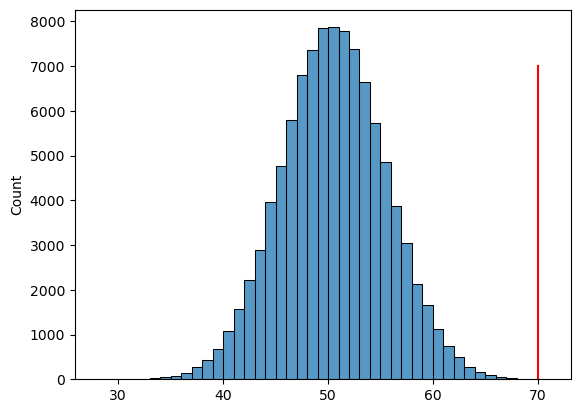

In [5]:
def tossCoins(n=100):
    return np.sum(rng.uniform(size=n) > 0.5)

# use a large number of replications since this is fast
coinFlips = np.array([tossCoins() for i in range(100000)])

sns.histplot(coinFlips, binwidth=1)
plt.plot([70, 70], [0, 7000], color='red')

## Table 9.2

In [6]:
def roundToNearest5(x, base = 5):
  return(base * np.round(x / base))

squatDf = pd.DataFrame({'group': 5 * ['FB'] + 5 * ['XC'],
                       'squat': roundToNearest5(
                           np.hstack((rng.normal(size=5) * 30 + 300,
                                      rng.normal(size=5) * 30 + 140))).astype('int')})

squatDf['shuffledSquat'] = rng.permuted(squatDf.squat.values)

squatDf

,group,squat,shuffledSquat
0,FB,315,160
1,FB,295,125
2,FB,275,140
3,FB,320,105
4,FB,290,175
5,XC,105,290
6,XC,140,320
7,XC,125,295
8,XC,160,275
9,XC,175,315


## Figure 9.4

Text(0, 0.5, 'max squat (lbs)')

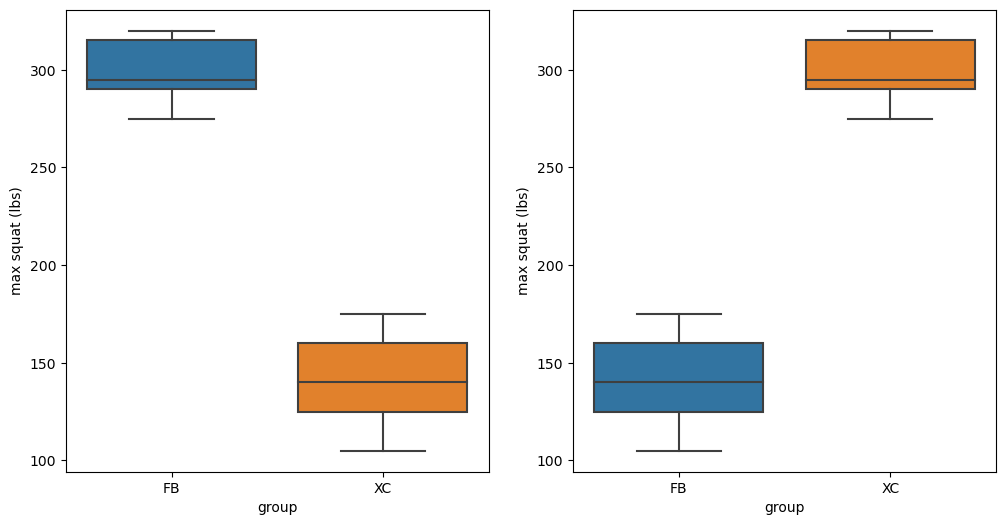

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.boxplot(data=squatDf, x='group', y='squat', ax=ax[0])
ax[0].set_ylabel('max squat (lbs)')

sns.boxplot(data=squatDf, x='group', y='shuffledSquat', ax=ax[1])
ax[1].set_ylabel('max squat (lbs)')


## Two-group t-test:

In [8]:
tt = pg.ttest(x=squatDf.query('group == "FB"').squat, 
              y=squatDf.query('group == "XC"').squat,
              alternative='greater', correction=True)
tt

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.604266,6.977154,greater,0.000007,"[129.76, inf]",6.706726,3708.105,1.0


## Figure 9.5

In [9]:
nRuns = 10000

def shuffleAndMeasure(df):
    dfScram = df.copy()
    dfScram['squat'] = rng.permuted(df.squat.values)
    tt = pg.ttest(x=dfScram.query('group == "FB"').squat, 
                  y=dfScram.query('group == "XC"').squat,
                  alternative='greater', correction=True)
    return(tt['T'][0])

shuffleDist = np.array([shuffleAndMeasure(squatDf) for i in range(nRuns)])



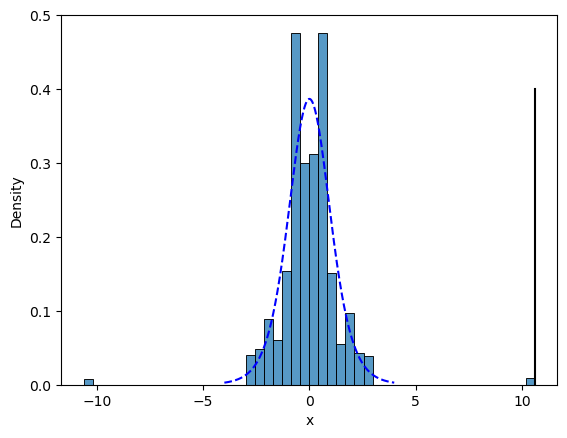

In [10]:
pvalRandomization = np.mean(shuffleDist >= tt['T'][0])

sns.histplot(shuffleDist, bins=50, stat='density')
distDfNormal['dt8'] = t.pdf(distDfNormal.x, 8)
sns.lineplot(data=distDfNormal, x='x',  y='dt8', color='blue', linestyle='dashed')
plt.plot([tt['T'][0], tt['T'][0]], [0, .4], color='black')

## Figure 9.6

In [11]:

def shuffleBPstat(df):
    dfScram = df.copy()
    dfScram['BPSysAve'] = rng.permuted(df.BPSysAve.values)
    tt = pg.ttest(x=dfScram.query('PhysActive == "No"').BPSysAve, 
                  y=dfScram.query('PhysActive == "Yes"').BPSysAve,
                  correction=True)
    return(tt['T'][0])

nRuns = 10000
meanDiffSim = np.array([shuffleBPstat(NHANES_sample) for i in range(nRuns)])

In [12]:
bp_tt = pg.ttest(x=NHANES_sample.query('PhysActive == "No"').BPSysAve, 
                  y=NHANES_sample.query('PhysActive == "Yes"').BPSysAve,
                  correction=True)
bp_tt

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.291071,227.56194,two-sided,0.022874,"[0.77, 10.2]",0.292623,1.638,0.634066


Text(0.5, 0, 'T stat: BP difference between groups')

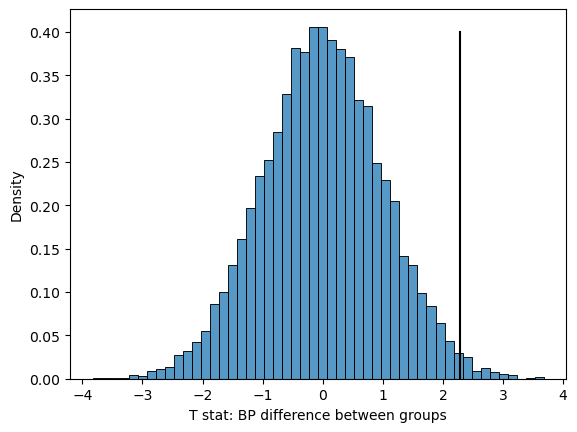

In [13]:
pvalRandomization = np.mean(meanDiffSim >= tt['T'][0])

sns.histplot(meanDiffSim, bins=50, stat='density')
plt.plot([bp_tt['T'][0], bp_tt['T'][0]], [0, .4], color='black')
plt.xlabel("T stat: BP difference between groups")

## Figure 9.7

In [14]:
def exerciseTrial(nPerGroup, bpReduction=0.5):
    bp_mean = NHANES_adult.BPSysAve.mean()
    bp_sd = NHANES_adult.BPSysAve.std()
    controlGroup = rng.normal(bp_mean, bp_sd, nPerGroup)
    expGroup = rng.normal(bp_mean - bpReduction, bp_sd, nPerGroup)
    bp_tt = pg.ttest(x=controlGroup,
                     y=expGroup,
                     correction=True)
    return([nPerGroup, bpReduction, bp_tt['p-val'][0], controlGroup.mean() - expGroup.mean()])



nRuns = 1000
sampSizes = 2 ** np.arange(5,18) # powers of 2
simResults = []

for i, n in enumerate(sampSizes):
    runResults = [exerciseTrial(n) for i in range(nRuns)]
    runResultsDf = pd.DataFrame(runResults,
                                columns=['nPerGroup', 'bpReduction', 'pval', 'diff'])
    simResults.append([n, np.mean(runResultsDf.pval < .05), runResultsDf['diff'].mean()])

simResultsDf = pd.DataFrame(simResults, columns=['n', 'psig', 'meandiff'])



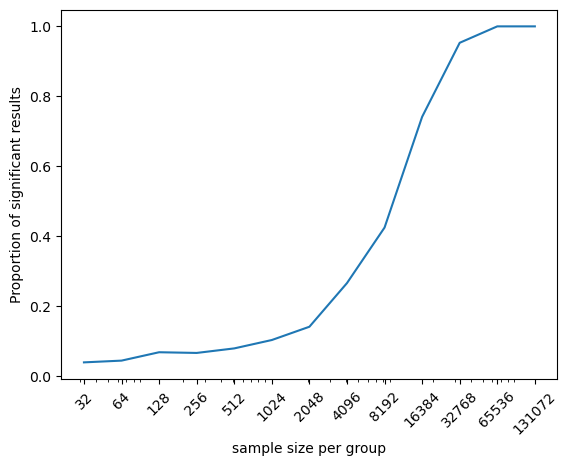

In [15]:
p = sns.lineplot(data=simResultsDf, x='n', y='psig')
plt.xscale('log')
plt.ylabel('Proportion of significant results')
plt.xlabel('sample size per group') 
_ = plt.xticks(simResultsDf.n, rotation=45)
p.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

## Figure 9.8

Text(0.5, 0, 'Number of significant results (out of 1000000)')

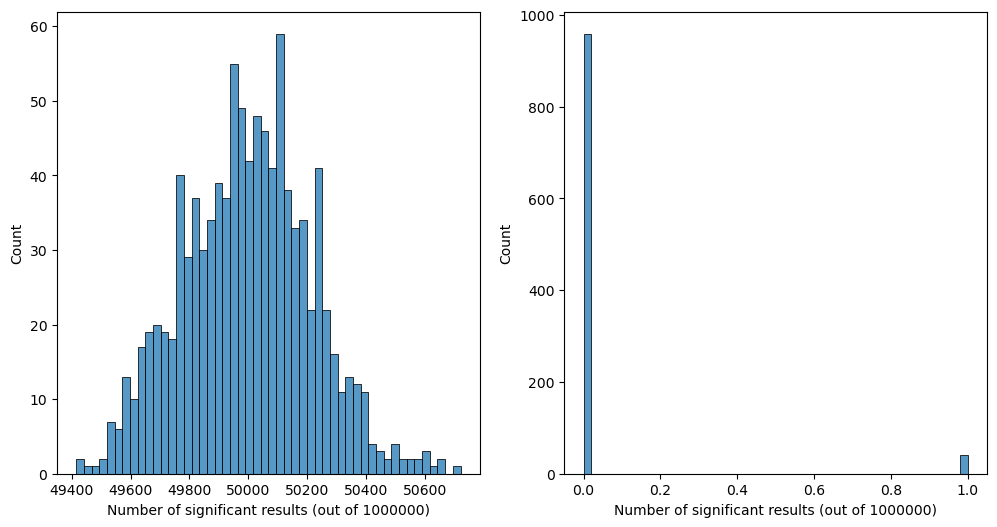

In [16]:
nRuns = 1000 # number of simulated studies to run
nTests = 1000000 # number of simulated genes to test in each run

uncAlpha = 0.05 # alpha level
cutoff = norm.ppf(uncAlpha)
cor_cutoff = norm.ppf(uncAlpha/nTests)

uncOutcome = []
corOutcome = []
for i in range(nRuns):
    sample = rng.normal(size=nTests)
    uncOutcome.append(np.sum(sample < cutoff))
    corOutcome.append(np.sum(sample < cor_cutoff))

fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.histplot(uncOutcome, bins=50, ax=ax[0])
sns.histplot(corOutcome, bins=50, ax=ax[1])
ax[0].set_xlabel(f'Number of significant results (out of {nTests})')
ax[1].set_xlabel(f'Number of significant results (out of {nTests})')

